# LCPB 22-23 Exercise 2 (Clustering and DBSCAN) 

<center><h1>Group 2307</h1></center>


<center><style>
table {
    font-size: 24px;
}
</style></center>

| Last Name          | First Name            |Matricola number|
|--------------------|-----------------------|----------------|
| Bertinelli         | Gabriele              |1219907 (tri)   |
| Cacciola           | Martina               |2097476         |
| Pervysheva         | Yelyzaveta            |2039398         |           
| Waththe Liyanage   | Wageesha Widuranga    |2078719         |

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 15

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 600   D= 3


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [3]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

569.5269005085432
mean minimum distance between points:  23.321029500210262


## t-SNE visualization, for true labels

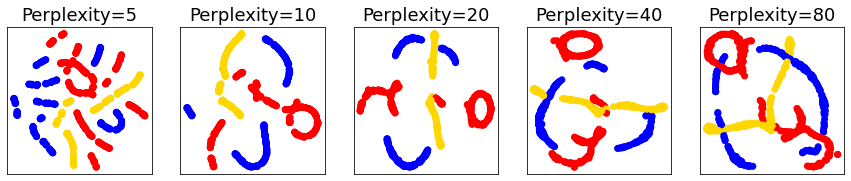

In [4]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = []
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Task 1

We fixed the perplexity value to 20, because you can see, from the previous cell, that it gives the best result.
In the following cell we vary the number of the `random_state` (aka the seed). You can see that there's not much difference in clustering. The plots are all more or less the same except for some rotations or reshuffling, but with the same color-coded clustering.

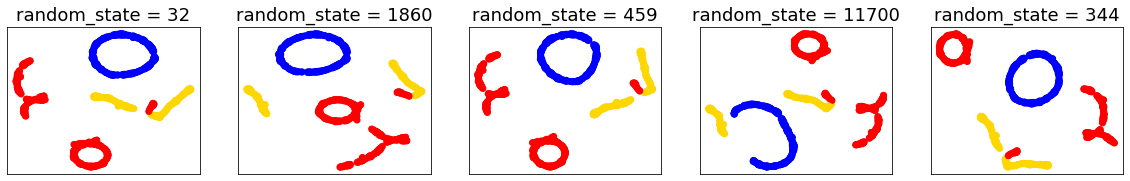

In [5]:
rnd_states = [32, 1860, 459, 11700, 344]
Nr = len(rnd_states)

(fig, subplots) = plt.subplots(1, Nr, figsize=(4 * Nr, 2.7))

X_all = [None]
for i, rnd in enumerate(rnd_states):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=rnd, perplexity=20)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title(f"random_state = {rnd}")
    ax.scatter(Y[:, 0], Y[:, 1], c=y, cmap=mycmap)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    X_all.append(Y)
    
plt.show()

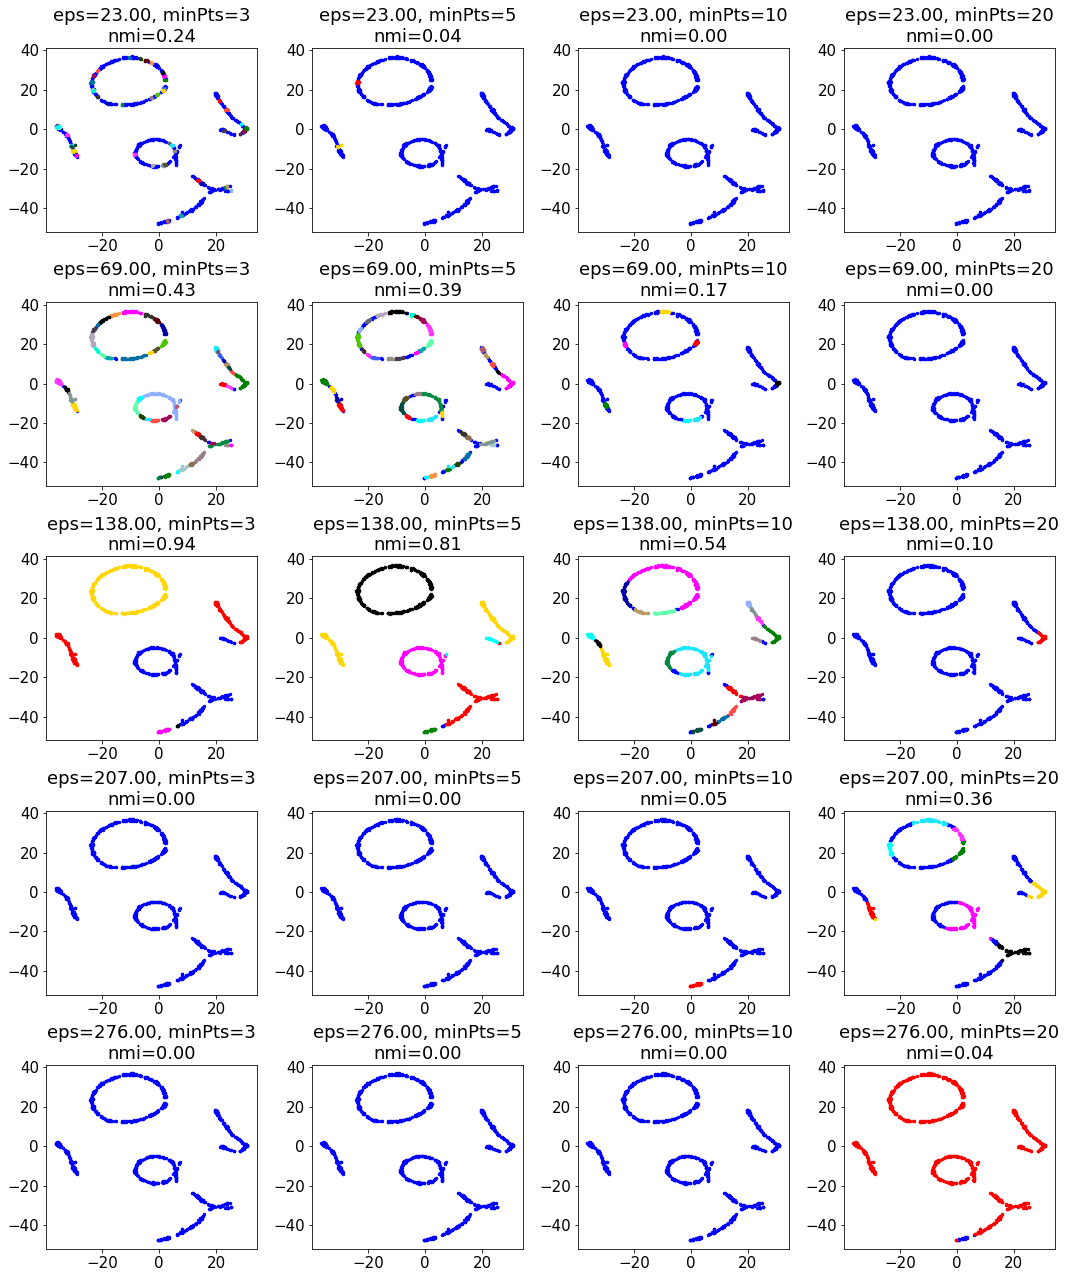

In [6]:
from sklearn.cluster import DBSCAN
# from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of
    # cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r,3*r,6*r,9*r,12*r]
min_sample_range = [3,5,10,20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i,j])
        nmi=NMI(y_hat, y_true)
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()

## Task 2) DBSCAN: find labels by applying clustering

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a clustering algorithm that groups together points that are closely packed together and separated from other dense regions of points. The algorithm takes two input parameters: "eps" and "minPts".

eps (epsilon) is the radius of the neighborhood around a point. It defines the maximum distance between two points for them to be considered as part of the same cluster. Points within this radius are considered "neighbors" of each other.

minPts (minimum number of points) is the minimum number of points needed to form a dense region (i.e., a cluster). If there are fewer than minPts points within the eps radius of a point, that point is labeled as noise and not considered part of any cluster.

To refine the grid with more values of "eps" and "minPts", we can increase the number of values in the range of values used for each parameter. This will result in a larger heat-map showing more combinations of "eps" and "minPts" values and their corresponding NMI values.

There may be a correlation between "eps" and "minPts" in providing a high NMI, as both parameters influence the clustering results. In general, increasing "eps" allows for more points to be considered part of the same cluster, while increasing "minPts" requires a higher density of points for a cluster to form. The optimal combination of "eps" and "minPts" values will depend on the specific dataset and the desired clustering result.

To further tune "eps" and "minPts", we can plot ranked distances and visually inspect the plot to identify a suitable value for "eps"

In [15]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import OrderedDict

# Load data
data = np.loadtxt("DATA/x_3d.dat", delimiter='\t')
y_true = np.loadtxt("DATA/y_3d.dat", dtype=int)

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(data)

# Define range of values for eps and minPts
eps_range = np.linspace(0.1, 2.0, 20)
minPts_range = np.arange(1, 21)

# Create an empty array to store the NMI values
NMI_array = np.zeros((len(eps_range), len(minPts_range)))

# Loop over the range of values for eps and minPts
for i, eps in enumerate(eps_range):
    for j, minPts in enumerate(minPts_range):
        # Fit DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=minPts)
        y_pred = dbscan.fit_predict(X)
        
        # Compute NMI and store in array
        NMI_array[i, j] = NMI(y_true, y_pred)

<bound method _AxesBase.set_yticklabels of <AxesSubplot:>>

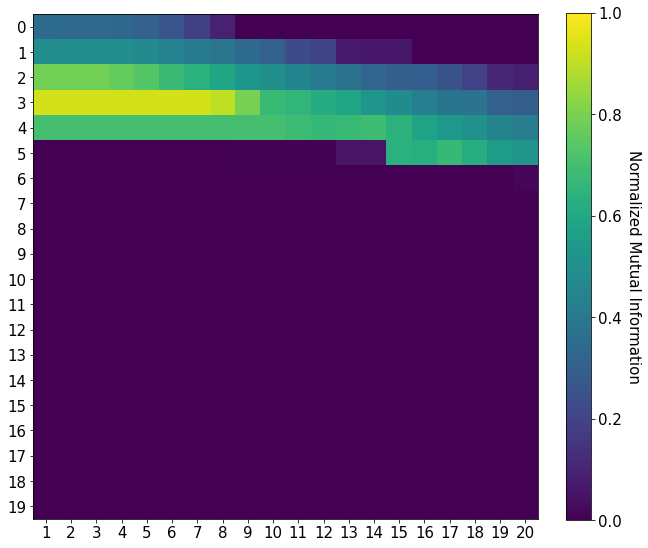

In [20]:
# Plot heat-map of NMI values
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(NMI_array, cmap='viridis', vmin=0.0, vmax=1.0)

# Add color-bar
cbar = ax.figure.colorbar(im, ax=ax, fraction=0.0455)
cbar.ax.set_ylabel('Normalized Mutual Information', rotation=-90, va="bottom")

# Add ticks and labels
ax.set_xticks(np.arange(len(minPts_range)))
ax.set_yticks(np.arange(len(eps_range)))
ax.set_xticklabels(['{}'.format(x) for x in minPts_range])
ax.set_yticklabels